In this notebook I am going to finalize, in which way should I use my models so that I get maximum performance. 
<br>
Since we have three models one machine learning, one CNN model and one NLP model all trained on different data. So, we have to find a method to combine all models so that we get maximum performance.

In [2]:
!pip install tensorflow-text

     |████████████████████████████████| 4.3MB 8.4MB/s 


In [3]:
#importing libraries
import pandas as pd
import numpy as np
from numpy import asarray
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os
from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import load_model
import tensorflow_text as text
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
#loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Applied_ai/test dataset/test_dataset.csv')

In [15]:
df.shape

(4984, 68)

In [16]:
'''
during object detection in image I have exteacted 3 objects with their respective probabilities. The probability values
are stored in a list and list is in the form of string. SO I am going to convert them back to list and will make three
different features for these probabilities.
'''

#converting lists of string type to list
from ast import literal_eval
df['img_feature_pred'] = df['img_feature_pred'].apply(literal_eval)

In [17]:
#getting probabitity values in three different lists to make them as seperate features
img_feature_pred_1 = []
img_feature_pred_2 = []
img_feature_pred_3 = []
for i in df['img_feature_pred']:
  img_feature_pred_1.append(i[0])
  img_feature_pred_2.append(i[1])
  img_feature_pred_3.append(i[2])

In [18]:
#creating features for probability values
df['img_feature_pred_1'] = img_feature_pred_1
df['img_feature_pred_2'] = img_feature_pred_2
df['img_feature_pred_3'] = img_feature_pred_3

In [19]:
y = df['dank_or_not']
X = df.drop(['dank_or_not'], axis=1)

Since our project is to predict the dankness of the meme and it will be done before posting the meme on social networking sites. So, before posting data such as num_comments, upvote_ratio, score etc will not be available for the post and also it will be good if we predict the dankness of memes irrespective of subscribers count on the page. So, I am going to drop those features.

In [8]:
#dropping features as discussed above
df.drop(['img_feature_pred','is_original_content','num_comments','upvote_ratio','score','subreddit_subscribers'], axis=1, inplace=True)

<br>

## Seperating datasets to predict from different models

In [9]:
#Dataset for machine learning model
X_ml = X[['img_feature_pred_1','img_feature_pred_2','img_feature_pred_3','avg_h','avg_s','avg_v','sentiment_score','hour',
    'num_words','thumbnail_height','thumbnail_width','gray', 'white', 'faded colors', 'black', 'dark blue', 'goldish',
    'light blue', 'brown', 'yellow', 'dark cyan', 'light orange', 'dark green', 'cyan', 'off-white', 'dark red', 
    'dark orange', 'light red','web_site','book_jacket','packet','mud_turtle']]

In [19]:
#dataset for CNN model
X_cnn = df[['url']]
X_cnn.url = X_cnn.url.str.split('/').str[-1] + ('.png')
X_cnn = pd.DataFrame(X_cnn)

In [12]:
#dataset for NLP model
X_bert = df['text']

<br>

## Loading models

In [13]:
#ML model
ml_model = pickle.load(open('/content/drive/MyDrive/Applied_ai/models/dankornot_ml/dankornot_ml.pkl', 'rb'))

In [14]:
#CNN model
cnn_model = load_model('/content/drive/MyDrive/Applied_ai/models/resnet_model/resnet_model.h5')

In [15]:
#bert model
bert_model = tf.saved_model.load('/content/drive/MyDrive/Applied_ai/models/bert_model/content/bert_model')

<br>

## **Predictions**

### Predicting using ML model

In [16]:
ml_pred_prob = ml_model.predict_proba(X_ml)[:,-1]
ml_pred = ml_model.predict(X_ml)

### Predicting using CNN model

In [21]:
#Reference : https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/
cnn_pred_prob = []
for image in tqdm(X_cnn.url, position=0):
  path = '/content/drive/MyDrive/Applied_ai/meme_images/'+image
  img = Image.open(path)
  pixels = asarray(img)
  pixels = pixels.astype('float32')
  pixels /= 255.0
  pixels.resize(224,224,3)
  pixels = np.expand_dims(pixels, axis=0)
  cnn_prediction = cnn_model.predict(pixels)
  cnn_pred_prob.append(cnn_prediction[0][0])

100%|██████████| 4984/4984 [1:01:41<00:00,  1.35it/s]


In [24]:
cnn_pred = np.array(cnn_pred_prob).round().astype('int')

### Predicting using NLP model

In [28]:
nlp_pred_prob = []
for text in tqdm(X_bert, position=0):
  try:
    bert_predict = tf.sigmoid(bert_model(tf.constant([text])))
    nlp_pred_prob.append(np.array(bert_predict)[0][0])
  except:
    nlp_pred_prob.append(0)

100%|██████████| 4984/4984 [00:35<00:00, 141.98it/s]


In [31]:
nlp_pred = np.array(nlp_pred_prob).round().astype('int')

## Creating a dataset of predicted probabilities values

In [33]:
prob_pred_df = pd.DataFrame(columns = ['ml_pred','cnn_pred','nlp_pred'])

In [34]:
prob_pred_df['ml_pred'] = ml_pred_prob
prob_pred_df['cnn_pred'] = cnn_pred_prob
prob_pred_df['nlp_pred'] = nlp_pred_prob

## Creating a dataset of predicted labels

In [35]:
pred_df = pd.DataFrame(columns = ['ml_pred','cnn_pred','nlp_pred'])

In [36]:
pred_df['ml_pred'] = ml_pred
pred_df['cnn_pred'] = cnn_pred
pred_df['nlp_pred'] = nlp_pred

### Performance of models by taking mean of probability values.
<br>
Here I am going to combine all the three models by taking the mean of probability values predicted by them for each data. According to that mean value I will get predicted labels and compare these labes with original labels.

In [8]:
prob_pred_df = pd.read_csv('/content/drive/MyDrive/Applied_ai/datasets/prob_pred_df')
pred_df = pd.read_csv('/content/drive/MyDrive/Applied_ai/datasets/pred_df')

In [10]:
mean_all = prob_pred_df.mean(axis=1)
mean_ml_cnn = prob_pred_df[['ml_pred','cnn_pred']].mean(axis=1)
mean_cnn_nlp = prob_pred_df[['cnn_pred','nlp_pred']].mean(axis=1)
mean_nlp_ml = prob_pred_df[['nlp_pred','ml_pred']].mean(axis=1)

In [21]:
label_all = mean_all.round().astype('int')
label_ml_cnn = mean_ml_cnn.round().astype('int')
label_cnn_nlp = mean_cnn_nlp.round().astype('int')
label_nlp_ml = mean_nlp_ml.round().astype('int')

In [22]:
print('Accuracy all : ', accuracy_score(label_all, y))
print('Accuracy ml_cnn : ', accuracy_score(label_ml_cnn, y))
print('Accuracy cnn_nlp : ', accuracy_score(label_cnn_nlp, y))
print('Accuracy nlp_ml : ', accuracy_score(label_nlp_ml, y))

Accuracy all :  0.791131621187801
Accuracy ml_cnn :  0.8802166934189406
Accuracy cnn_nlp :  0.4871589085072231
Accuracy nlp_ml :  0.7375601926163724


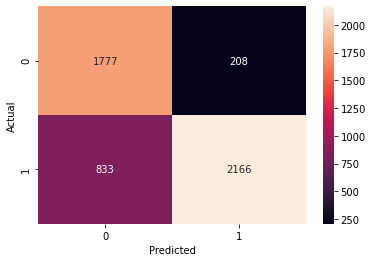

In [51]:
#plotting confusion matrix
cm = confusion_matrix(prob_pred_df['label'], y)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Performance of models by taking mode of labels.
<br>
Here I am going to take the mode of labels predicted by each model and that mode will be our final prediced label by all models. Then I will compare this mode with original target value.

In [36]:
mode_all = pred_df.mode(axis=1)

In [38]:
print('Accuracy : ', accuracy_score(mode_all, y))

Accuracy :  0.7935393258426966


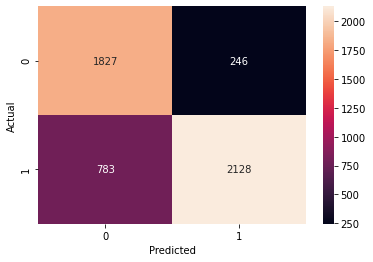

In [39]:
#plotting confusion matrix
cm_p = confusion_matrix(mode_all, y)
sns.heatmap(cm_p, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Passing predicted probabilities to a machine learning algorithm.
<br>
Here I am going to train a machine learning model using probabilities values.

In [59]:
#using logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [60]:
params = {'max_iter' : [100,500,1000,2000]}

In [68]:
lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid=params, scoring='accuracy', cv=5, return_train_score=True)

In [69]:
X = prob_pred_df[['ml_pred', 'cnn_pred', 'nlp_pred']]
y = y

In [70]:
#training the model
clf.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_iter': [100, 500, 1000, 2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [76]:
print('logistic regression cv train score : ',clf.cv_results_['mean_train_score'].mean())

logistic regression cv train score :  0.8897473332966042


In [77]:
print('logistic regression cv test score : ',clf.cv_results_['mean_test_score'].mean())

logistic regression cv test score :  0.8902508731012315


From all the three methods we can see that logistic regression is giving the highest accuracy than the mean and mode method. But we have very less data to train the machine learning model so, in this case mean and mode method looks more promising.<br>
Mean and mode methods are giving same accuracy, So I am going to use mean of probabilities predicted by all the three models.